In [ ]:
!pip install -U transformers

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile

zip_path = "/content/drive/MyDrive/final project/archive (8).zip"
extract_path = "intel_image_dataset"

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


In [ ]:
import os

# List the top-level files and directories
extracted_path = "intel_image_dataset"
print(os.listdir(extracted_path))

['seg_pred', 'seg_train', 'seg_test']


In [ ]:

# Set paths
base_dir = "/content/intel_image_dataset"
train_dir = os.path.join(base_dir, "seg_train")
test_dir = os.path.join(base_dir, "seg_test")
pred_dir = os.path.join(base_dir, "seg_pred")

In [ ]:

!pip install -q tensorflow transformers


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification
import torch.nn as nn
from tqdm import tqdm
from torch.optim import AdamW

In [ ]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.utils import shuffle

# Set paths
base_dir = "/content/intel_image_dataset"
train_dir = os.path.join(base_dir, "seg_train", "seg_train")
test_dir = os.path.join(base_dir, "seg_test", "seg_test")

# Label mapping
label_map = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

def load_images_from_directory(directory):
    images, labels = [], []
    class_names = sorted(os.listdir(directory))
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for image_file in os.listdir(class_path):
            img_path = os.path.join(class_path, image_file)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = image / 255.0
                images.append(image)
                labels.append(label_map[class_name])
    return shuffle(np.array(images), np.array(labels), random_state=42), list(label_map.keys())

# Load and shuffle data
(X_train, y_train), class_names = load_images_from_directory(train_dir)
(X_test, y_test), _ = load_images_from_directory(test_dir)

# Encode labels and one-hot encode
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [ ]:
import os
import cv2
import numpy as np

def get_images(train_dir):
    """
    Loads images and their corresponding labels from a directory.

    Args:
        data_dir: Path to the directory containing the image data.

    Returns:
        A tuple containing two lists:
            images: A list of NumPy arrays representing the images.
            labels: A list of corresponding labels for the images.
    """
    images = []
    labels = []
    label_map = {
        'buildings': 0,
        'forest': 1,
        'glacier': 2,
        'mountain': 3,
        'sea': 4,
        'street': 5
    }
    for label in os.listdir(train_dir):
        label_dir = os.path.join(train_dir, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                img_path = os.path.join(label_dir, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label_map[label])
    return images, labels


Images, Labels = get_images('/content/intel_image_dataset/seg_train')

Images = np.array(Images)
Labels = np.array(Labels)

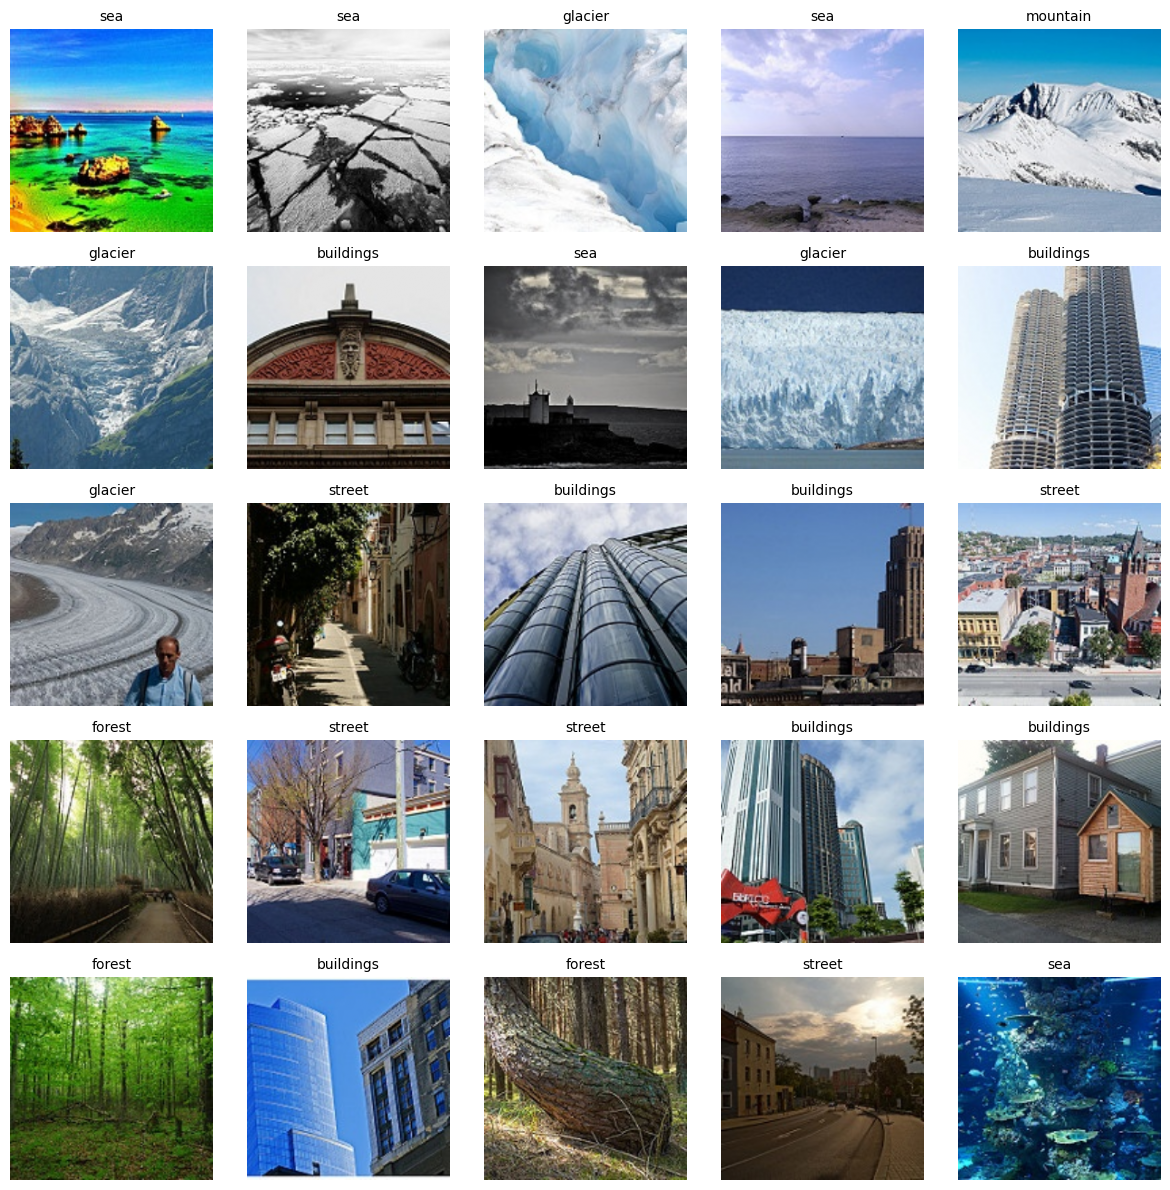

In [ ]:
import matplotlib.pyplot as plt
from random import randint


def get_classlabel(class_code):
    label_map = {
        0: 'buildings',
        1: 'forest',
        2: 'glacier',
        3: 'mountain',
        4: 'sea',
        5: 'street'
    }
    return label_map[class_code]


fig, ax = plt.subplots(5, 5, figsize=(12, 12))
fig.subplots_adjust(left=0, right=1.5, top=1.5, bottom=0)

# Display 25 random images with their class labels
for i in range(5):
    for j in range(5):
        rnd_number = randint(0, len(X_train) - 1)
        ax[i, j].imshow(X_train[rnd_number])
        ax[i, j].set_title(get_classlabel(np.argmax(y_train[rnd_number])), fontsize=10) # Call the defined get_classlabel function
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Print dataset shapes
print(f'X_train.shape = {X_train.shape}; y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}; y_test.shape = {y_test.shape}')

X_train.shape = (14034, 224, 224, 3); y_train.shape = (14034, 6)
X_test.shape = (3000, 224, 224, 3); y_test.shape = (3000, 6)


In [ ]:
class IntelDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Normalize([0.5], [0.5])
])

train_dataset = IntelDataset(X_train, y_train, transform=transform)
test_dataset = IntelDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(class_names),
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

def train_model(model, loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels.argmax(dim=1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels.argmax(dim=1)).sum().item()
            total += labels.size(0)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.4f}, Accuracy: {correct/total:.4f}")

train_model(model, train_loader, optimizer, criterion, epochs=5)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 439/439 [01:42<00:00,  4.27it/s]


Epoch [1/5], Loss: 0.2432, Accuracy: 0.9262


100%|██████████| 439/439 [01:41<00:00,  4.32it/s]


Epoch [2/5], Loss: 0.0909, Accuracy: 0.9706


100%|██████████| 439/439 [01:42<00:00,  4.30it/s]


Epoch [3/5], Loss: 0.0417, Accuracy: 0.9875


100%|██████████| 439/439 [01:41<00:00,  4.31it/s]


Epoch [4/5], Loss: 0.0203, Accuracy: 0.9950


100%|██████████| 439/439 [01:41<00:00,  4.31it/s]

Epoch [5/5], Loss: 0.0112, Accuracy: 0.9972


In [ ]:
def evaluate_model(model, loader):
    model.eval()
    correct, total, loss_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels.argmax(dim=1))
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels.argmax(dim=1)).sum().item()
            total += labels.size(0)
            loss_total += loss.item()
    print(f"Test Loss: {loss_total/len(loader):.4f}, Test Accuracy: {correct/total:.4f}")

evaluate_model(model, test_loader)


Test Loss: 0.2132, Test Accuracy: 0.9493


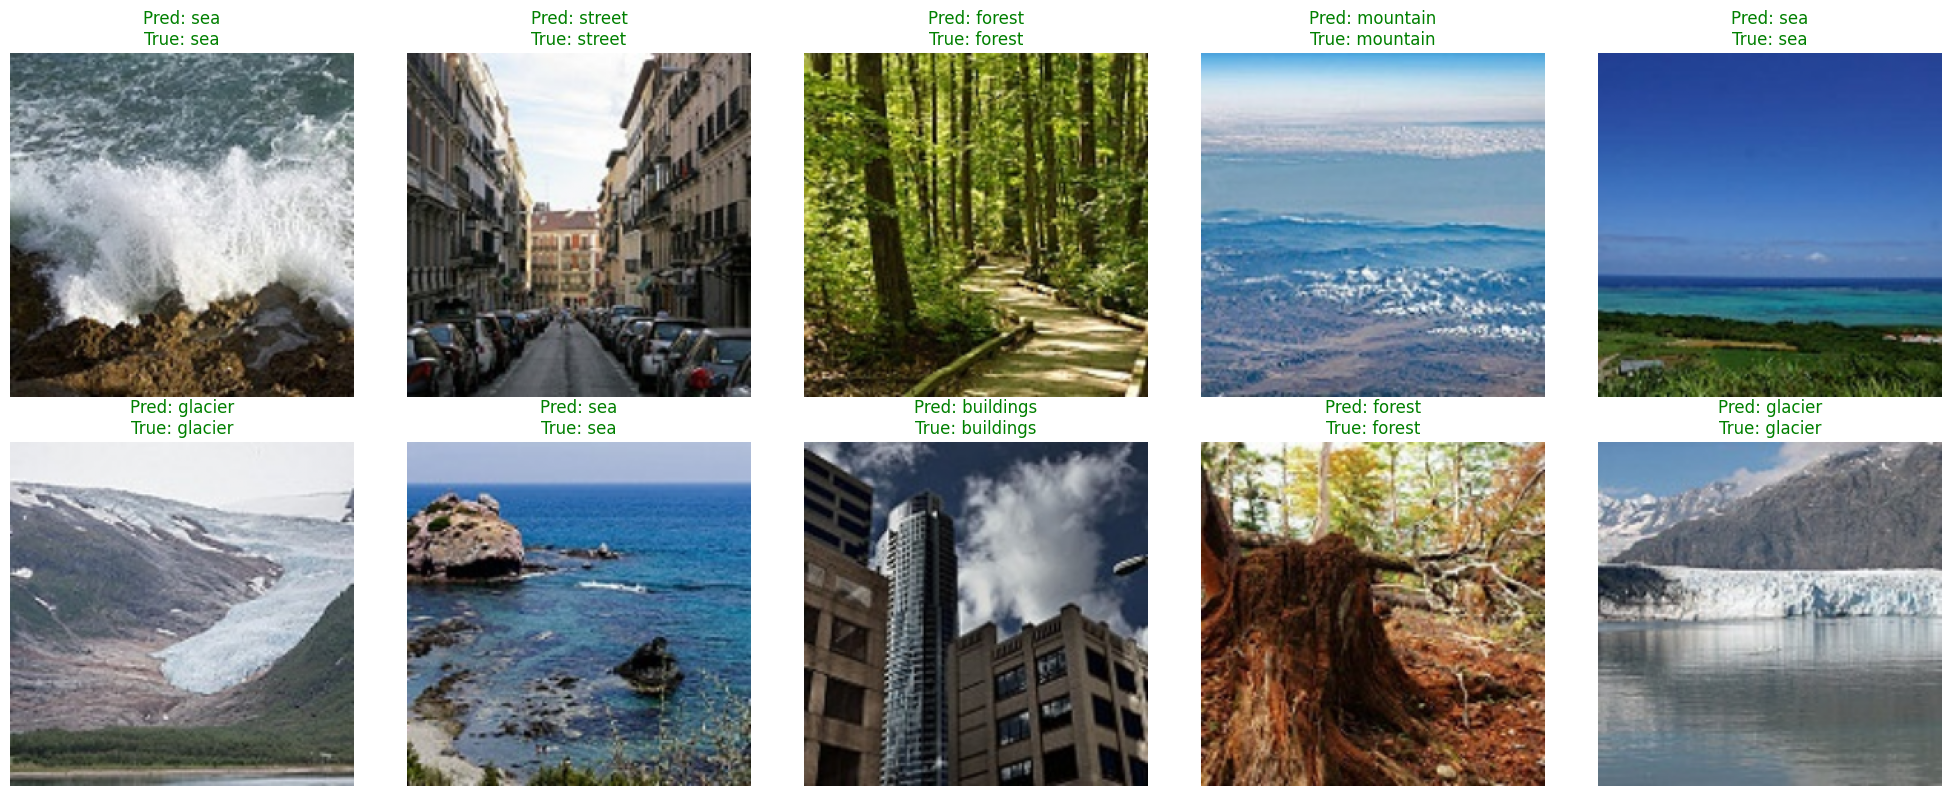

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np


inv_classes = {v: k for k, v in enumerate(le.classes_)} if hasattr(le, "classes_") else {i: name for i, name in enumerate(class_names)}

model.eval()


N = 10
indices = np.random.choice(len(X_test), size=N, replace=False)
sample_images = X_test[indices]
sample_labels = y_test[indices]


sample_tensors = torch.tensor(sample_images, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

# Perform predictions
with torch.no_grad():
    outputs = model(sample_tensors).logits
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

# Plot images with predictions and true labels
plt.figure(figsize=(20, 8))
for i in range(N):
    plt.subplot(2, N//2, i+1)
    plt.imshow(sample_images[i])
    true_label = get_classlabel(np.argmax(sample_labels[i]))
    pred_label = get_classlabel(predictions[i])
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='green' if true_label == pred_label else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload your ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")


Saving Untitled27.ipynb to Untitled27.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>